In [11]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Get Data

In [12]:
test_df = pd.read_csv('test_simplified.csv')
test_df.shape

(112199, 3)

In [13]:
# Get names of all train csv files with the pattern match below
fnames = glob('train_simplified/*.csv')

In [14]:
rows = 200
# Get n rows from all the csv files and append them into one dataframe
train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=20).columns)
for name in fnames:
    data = pd.read_csv(name, nrows=rows)
    train_df = train_df.append(data)
train_df = train_df.reset_index().drop('index', axis=1)
# Get only those which were correctly recognized
train_df = train_df[train_df['recognized'] == True]

In [15]:
# Convert the drawing column to matrix
train_df['drawing'] = train_df['drawing'].apply(ast.literal_eval)
test_df['drawing'] = test_df['drawing'].apply(ast.literal_eval)

In [26]:
train_df['drawing'][2]

[[[32, 91, 255], [32, 48, 70]],
 [[179, 146, 47, 1, 5], [70, 65, 62, 49, 47]],
 [[228, 209, 116, 15], [17, 23, 22, 0]],
 [[124, 91], [36, 36]]]

# Draw Sample

In [17]:
train_df.sample(10)

,countrycode,drawing,key_id,recognized,timestamp,word
5664,US,"[[[73, 29, 9, 1, 0, 6, 14, 31, 59, 61, 50, 48,...",5492296726347776,True,2017-03-27 15:04:47.190490,teapot
38325,US,"[[[63, 50, 38, 14, 5, 0, 0, 14, 40, 77, 114, 1...",6165915894808576,True,2017-01-27 15:07:09.294030,blueberry
61742,US,"[[[50, 22, 9, 1, 0, 11, 21, 62, 76, 89, 94, 95...",5510930207080448,True,2017-03-20 23:57:02.524820,headphones
28435,PL,"[[[5, 8, 24, 36, 53, 56], [22, 8, 1, 0, 12, 34...",4568107261624320,True,2017-01-29 16:18:19.193150,sleeping bag
63330,FI,"[[[84, 92, 93, 80], [255, 182, 111, 37]], [[76...",4601178845347840,True,2017-01-31 15:09:43.714190,streetlight
27711,US,"[[[39, 123, 186, 227, 252, 255, 222, 217, 188,...",5058779336933376,True,2017-03-18 17:13:03.407040,diamond
26282,JP,"[[[0, 35, 255], [49, 41, 17]], [[34, 46], [21,...",4882485177483264,True,2017-01-26 00:56:16.755050,stitches
60794,GB,"[[[141, 132, 113, 88, 75, 72, 74, 79, 81], [3,...",6572035096444928,True,2017-03-18 21:25:53.619080,spoon
61956,CA,"[[[36, 28, 17, 0, 1, 7, 30], [19, 19, 25, 42, ...",6573161015410688,True,2017-03-28 02:03:38.396430,horse
25440,US,"[[[101, 100], [62, 130]], [[164, 160], [61, 13...",6184950049013760,True,2017-01-30 01:39:16.354550,smiley face


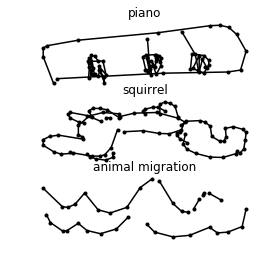

In [18]:
n_samp = 3
train_df_sample = train_df.sample(n_samp)
plt.figure(figsize=(4,4))
for i in range(n_samp):
    draw = train_df_sample.iloc[i]['drawing']
    label = train_df_sample.iloc[i]['word']
    plt.subplot(n_samp,1,i+1)
    for stroke in draw:
        plt.plot(stroke[0], stroke[1], marker='.', color='black')
        plt.title(label)
        plt.axis('off')
plt.show()    

# Convert drawings to images

In [19]:
def draw_it(raw_strokes, output_height, output_width):
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)

In [20]:
output_height = 32
output_width = 32
train_df['img'] = train_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)
test_df['img'] = test_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)

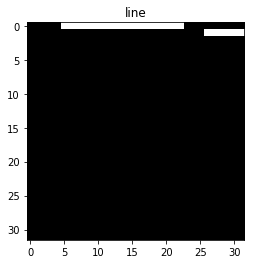

In [21]:
# Show an image
ind = 100
plt.imshow(train_df.iloc[ind]['img'],cmap='gray')
plt.title(train_df.iloc[ind]['word'])
plt.show()

# Create a baseline CNN

In [29]:
batch_size = 10
num_classes = len(fnames)
epochs = 12

### Data Preprocessing

In [30]:
# Shuffle the data
random.seed(111)
train_df = train_df.sample(train_df.shape[0])

In [31]:
# input image dimensions
img_rows, img_cols = output_height, output_width
input_shape = (img_rows, img_cols)

In [32]:
# Reshape the array
imgArr = np.vstack(train_df['img'].values).flatten().reshape((train_df['img'].shape[0], img_rows, img_cols))
imgArr_test = np.vstack(test_df['img'].values).flatten().reshape((test_df['img'].shape[0], img_rows, img_cols))

In [33]:
# In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
# In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
imgArr = imgArr.reshape(imgArr.shape[0], img_rows, img_cols, 1).astype('float32')
imgArr_test = imgArr_test.reshape(imgArr_test.shape[0], img_rows, img_cols, 1).astype('float32')

In [34]:
y_train = train_df['word']

In [35]:
# Convert class labels from categorical to numerical
unique_classes_list = y_train.unique()
map_class_to_numeric = {k: v for v, k in enumerate(y_train.unique())}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}
y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

# convert class vectors to binary class matrices
y_train_one_hot = keras.utils.to_categorical(y_train_numeric, num_classes)
num_classes = y_train_one_hot.shape[1]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(imgArr, y_train_one_hot, test_size=0.2)

In [37]:
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

### Model Architecture

In [38]:
num_filters = 8 # num of channels / filters
def baseline_conv_model(num_filters):
    model = Sequential()
    model.add(Conv2D(num_filters, (5,5), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (5,5), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (3,3), input_shape=(img_rows,img_cols,1), activation='relu')) 
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model

In [39]:
model = baseline_conv_model(num_filters)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 16)          2320      
__________

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50072 samples, validate on 12518 samples
Epoch 1/500
 - 35s - loss: 6.9587 - acc: 0.0034 - top_3_accuracy: 0.0102 - categorical_crossentropy: 6.9587 - val_loss: 5.8234 - val_acc: 0.0043 - val_top_3_accuracy: 0.0122 - val_categorical_crossentropy: 5.8234
Epoch 2/500
 - 40s - loss: 5.7927 - acc: 0.0042 - top_3_accuracy: 0.0132 - categorical_crossentropy: 5.7927 - val_loss: 5.7066 - val_acc: 0.0079 - val_top_3_accuracy: 0.0189 - val_categorical_crossentropy: 5.7066
Epoch 3/500
 - 32s - loss: 5.6597 - acc: 0.0094 - top_3_accuracy: 0.0254 - categorical_crossentropy: 5.6597 - val_loss: 5.4920 - val_acc: 0.0167 - val_top_3_accuracy: 0.0436 - val_categorical_crossentropy: 5.4920
Epoch 4/500
 - 30s - loss: 5.4711 - acc: 0.0161 - top_3_accuracy: 0.0429 - categorical_crossentropy: 5.4711 - val_loss: 5.3173 - val_acc: 0.0272 - val_top_3_accuracy: 0.0685 - val_categorical_crossentropy: 5.3173
Epoch 5/500
 - 30s - loss: 5.2923 - acc: 0.0247 - top_3_accuracy: 0.0606 - categorical_crossentrop

Epoch 40/500
 - 29s - loss: 3.2245 - acc: 0.2451 - top_3_accuracy: 0.4364 - categorical_crossentropy: 3.2245 - val_loss: 3.1627 - val_acc: 0.2837 - val_top_3_accuracy: 0.4742 - val_categorical_crossentropy: 3.1627
Epoch 41/500
 - 28s - loss: 3.1937 - acc: 0.2508 - top_3_accuracy: 0.4448 - categorical_crossentropy: 3.1937 - val_loss: 3.1413 - val_acc: 0.2840 - val_top_3_accuracy: 0.4778 - val_categorical_crossentropy: 3.1413
Epoch 42/500
 - 28s - loss: 3.1751 - acc: 0.2528 - top_3_accuracy: 0.4485 - categorical_crossentropy: 3.1751 - val_loss: 3.1180 - val_acc: 0.2866 - val_top_3_accuracy: 0.4804 - val_categorical_crossentropy: 3.1180
Epoch 43/500
 - 30s - loss: 3.1539 - acc: 0.2564 - top_3_accuracy: 0.4501 - categorical_crossentropy: 3.1539 - val_loss: 3.1034 - val_acc: 0.2897 - val_top_3_accuracy: 0.4901 - val_categorical_crossentropy: 3.1034
Epoch 44/500
 - 29s - loss: 3.1365 - acc: 0.2593 - top_3_accuracy: 0.4565 - categorical_crossentropy: 3.1365 - val_loss: 3.0870 - val_acc: 0.291

Epoch 79/500
 - 27s - loss: 2.6489 - acc: 0.3357 - top_3_accuracy: 0.5536 - categorical_crossentropy: 2.6489 - val_loss: 2.9665 - val_acc: 0.3169 - val_top_3_accuracy: 0.5205 - val_categorical_crossentropy: 2.9665
Epoch 80/500
 - 27s - loss: 2.6187 - acc: 0.3387 - top_3_accuracy: 0.5614 - categorical_crossentropy: 2.6187 - val_loss: 2.9958 - val_acc: 0.3160 - val_top_3_accuracy: 0.5183 - val_categorical_crossentropy: 2.9958
Epoch 81/500
 - 27s - loss: 2.6182 - acc: 0.3388 - top_3_accuracy: 0.5614 - categorical_crossentropy: 2.6182 - val_loss: 2.9720 - val_acc: 0.3159 - val_top_3_accuracy: 0.5186 - val_categorical_crossentropy: 2.9720
Epoch 82/500
 - 26s - loss: 2.5954 - acc: 0.3441 - top_3_accuracy: 0.5660 - categorical_crossentropy: 2.5954 - val_loss: 2.9694 - val_acc: 0.3163 - val_top_3_accuracy: 0.5249 - val_categorical_crossentropy: 2.9694
Epoch 83/500
 - 27s - loss: 2.5920 - acc: 0.3441 - top_3_accuracy: 0.5657 - categorical_crossentropy: 2.5920 - val_loss: 2.9595 - val_acc: 0.321

Epoch 118/500
 - 27s - loss: 2.3428 - acc: 0.3868 - top_3_accuracy: 0.6178 - categorical_crossentropy: 2.3428 - val_loss: 3.0169 - val_acc: 0.3169 - val_top_3_accuracy: 0.5197 - val_categorical_crossentropy: 3.0169
Epoch 119/500
 - 26s - loss: 2.3390 - acc: 0.3875 - top_3_accuracy: 0.6214 - categorical_crossentropy: 2.3390 - val_loss: 3.0307 - val_acc: 0.3192 - val_top_3_accuracy: 0.5185 - val_categorical_crossentropy: 3.0307
Epoch 120/500
 - 26s - loss: 2.3494 - acc: 0.3861 - top_3_accuracy: 0.6158 - categorical_crossentropy: 2.3494 - val_loss: 2.9893 - val_acc: 0.3263 - val_top_3_accuracy: 0.5292 - val_categorical_crossentropy: 2.9893
Epoch 121/500
 - 27s - loss: 2.3437 - acc: 0.3852 - top_3_accuracy: 0.6175 - categorical_crossentropy: 2.3437 - val_loss: 2.9985 - val_acc: 0.3227 - val_top_3_accuracy: 0.5283 - val_categorical_crossentropy: 2.9985
Epoch 122/500
 - 27s - loss: 2.3225 - acc: 0.3915 - top_3_accuracy: 0.6229 - categorical_crossentropy: 2.3225 - val_loss: 3.0237 - val_acc: 

Epoch 157/500
 - 26s - loss: 2.1839 - acc: 0.4172 - top_3_accuracy: 0.6520 - categorical_crossentropy: 2.1839 - val_loss: 3.0269 - val_acc: 0.3239 - val_top_3_accuracy: 0.5260 - val_categorical_crossentropy: 3.0269
Epoch 158/500
 - 27s - loss: 2.1735 - acc: 0.4204 - top_3_accuracy: 0.6542 - categorical_crossentropy: 2.1735 - val_loss: 3.0185 - val_acc: 0.3257 - val_top_3_accuracy: 0.5252 - val_categorical_crossentropy: 3.0185
Epoch 159/500
 - 27s - loss: 2.1686 - acc: 0.4199 - top_3_accuracy: 0.6556 - categorical_crossentropy: 2.1686 - val_loss: 3.0434 - val_acc: 0.3211 - val_top_3_accuracy: 0.5233 - val_categorical_crossentropy: 3.0434
Epoch 160/500
 - 26s - loss: 2.1770 - acc: 0.4167 - top_3_accuracy: 0.6530 - categorical_crossentropy: 2.1770 - val_loss: 3.0178 - val_acc: 0.3245 - val_top_3_accuracy: 0.5288 - val_categorical_crossentropy: 3.0178
Epoch 161/500
 - 27s - loss: 2.1598 - acc: 0.4231 - top_3_accuracy: 0.6576 - categorical_crossentropy: 2.1598 - val_loss: 3.0436 - val_acc: 

Epoch 196/500
 - 26s - loss: 2.0644 - acc: 0.4436 - top_3_accuracy: 0.6769 - categorical_crossentropy: 2.0644 - val_loss: 3.0598 - val_acc: 0.3208 - val_top_3_accuracy: 0.5242 - val_categorical_crossentropy: 3.0598
Epoch 197/500
 - 26s - loss: 2.0661 - acc: 0.4389 - top_3_accuracy: 0.6769 - categorical_crossentropy: 2.0661 - val_loss: 3.0770 - val_acc: 0.3199 - val_top_3_accuracy: 0.5236 - val_categorical_crossentropy: 3.0770
Epoch 198/500
 - 27s - loss: 2.0715 - acc: 0.4407 - top_3_accuracy: 0.6762 - categorical_crossentropy: 2.0715 - val_loss: 3.0618 - val_acc: 0.3195 - val_top_3_accuracy: 0.5264 - val_categorical_crossentropy: 3.0618
Epoch 199/500
 - 26s - loss: 2.0756 - acc: 0.4387 - top_3_accuracy: 0.6751 - categorical_crossentropy: 2.0756 - val_loss: 3.0775 - val_acc: 0.3225 - val_top_3_accuracy: 0.5236 - val_categorical_crossentropy: 3.0775
Epoch 200/500
 - 26s - loss: 2.0506 - acc: 0.4420 - top_3_accuracy: 0.6814 - categorical_crossentropy: 2.0506 - val_loss: 3.0800 - val_acc: 

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [131]:
# X_train.shape

(27200, 50, 50, 1)

In [85]:
import sys
sys.path

['',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python27.zip',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old',
 '/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload',
 '/Users/vaibhavb/Library/Python/2.7/lib/python/site-packages',
 '/usr/local/lib/python2.7/site-packages',
 '/usr/local/lib/python2.7/site-packages/PIL',
 '

In [8]:
from PIL import Image

In [10]:
# Image.new("P", (255,255))